This project uses the ARCH and GARCH (2,2) model to study the volatility of the S&P options. The ARCH model captures periods of high and volatility together. The real life stock volatilities are not constant and certain events like a war and new regulations of trades between countries can impact the volatilities of the stocks. Therefore, the accounting for high volatility periods in the stock data becomes could offer a better risk management and better trading strategies. The figures and program below demonstrate the S&P 100 stock options.

The parameters: 

The stock data used: S&P

Duration:

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from dateutil import parser
from dateutil.tz import tzutc
from arch import arch_model
from tqdm import trange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sns.set_style('darkgrid')

In [2]:
## First we plot the usual volatility if S&P 500.

In [13]:
spy = yf.download('SPY', start = '2010-01-01')

C:\Users\anshu\AppData\Local\Temp\ipykernel_32348\2350186576.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start = '2010-01-01')
[*********************100%***********************]  1 of 1 completed


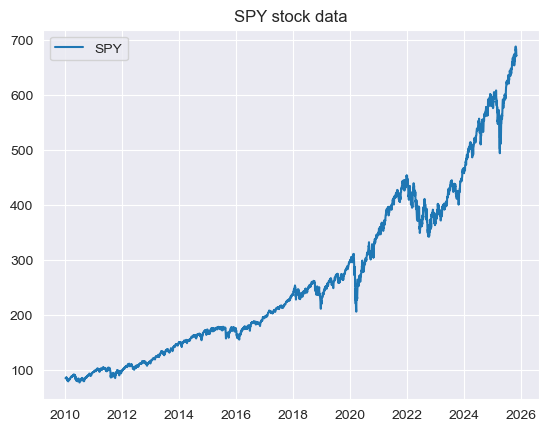

In [14]:
plt.plot(spy['Close','SPY'], label = 'SPY')

plt.title('SPY stock data')
plt.legend()
plt.show()

## Usual vs ARCH volatility

In [15]:
# Usual volatility turns out to be constant.
spy_usual_return = spy['Close','SPY'].pct_change()+1

spy_volatility = np.std(np.log(spy_usual_return))*np.sqrt(252)

In [16]:
spy_volatility

np.float64(0.17283294213498687)

### Now we plot the varied volatilities of the above stocks using GARCH model. To use the GARCH fit, we need to first plot the partial autocorrection graph.

Text(0.5, 1.0, 'S&P Returns')

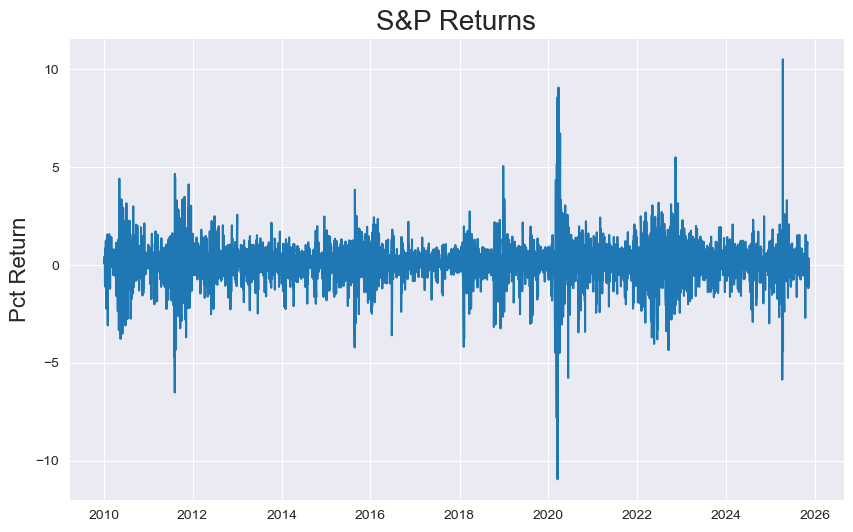

In [17]:
spy_returns= 100 * spy['Close','SPY'].pct_change().dropna()

plt.figure(figsize=(10,6))
plt.plot(spy_returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('S&P Returns', fontsize=20)

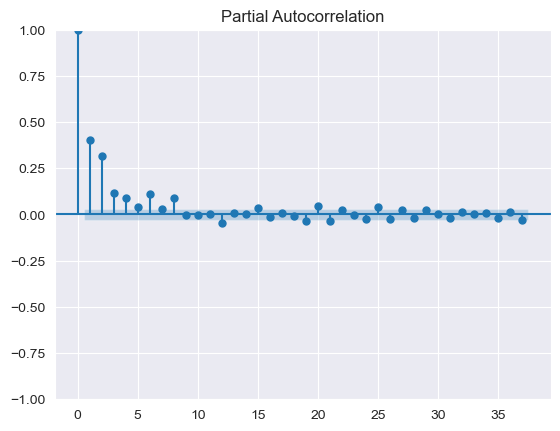

In [18]:
plot_pacf(spy_returns**2)
plt.show()

In [19]:
model = arch_model(spy_returns, p=2, q=2)

In [20]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 37802.7362513245
Iteration:      2,   Func. Count:     20,   Neg. LLF: 18510.92755957544
Iteration:      3,   Func. Count:     32,   Neg. LLF: 7672.291544554906
Iteration:      4,   Func. Count:     41,   Neg. LLF: 7154.636012937464
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5314.540093434554
Iteration:      6,   Func. Count:     59,   Neg. LLF: 5117.078003661032
Iteration:      7,   Func. Count:     67,   Neg. LLF: 5123.95203819326
Iteration:      8,   Func. Count:     75,   Neg. LLF: 5115.154540458243
Iteration:      9,   Func. Count:     82,   Neg. LLF: 5118.9184385067065
Iteration:     10,   Func. Count:     91,   Neg. LLF: 5116.062073149866
Iteration:     11,   Func. Count:     99,   Neg. LLF: 5114.427767569567
Iteration:     12,   Func. Count:    106,   Neg. LLF: 5114.41828181933
Iteration:     13,   Func. Count:    113,   Neg. LLF: 5114.417413743964
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5114.4173872

In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:       ('Close', 'SPY')   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5114.42
Distribution:                  Normal   AIC:                           10240.8
Method:            Maximum Likelihood   BIC:                           10278.6
                                        No. Observations:                 3987
Date:                Sat, Nov 08 2025   Df Residuals:                     3986
Time:                        11:09:17   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0890  1.189e-02      7.492  6.784e-14 [6.575e-02,  0.112]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0704  3.415e-02      2.062  3.919e-02  [3.493e-03,  0.137]
alpha[1]       0.1416  6.375e-02      2.221  2.636e-02  [1.663e-02,  0.267]
alpha[2]       0.1636  8.815e-02      1.856  6.338e-02 [-9.121e-03,  0.336]
beta[1]    8.7843e-17      1.085  8.095e-17      1.000    [ -2.127,  2.127]
beta[2]        0.6341      0.913      0.695      0.487    [ -1.155,  2.423]
===========================================================================

Covariance estimator: robust
"""

In [25]:
rolling_predictions = []
test_size = 365*5

for i in range(test_size):
    train = spy_returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [28]:
rolling_predictions = pd.Series(rolling_predictions, index=spy_returns.index[-365*5:])

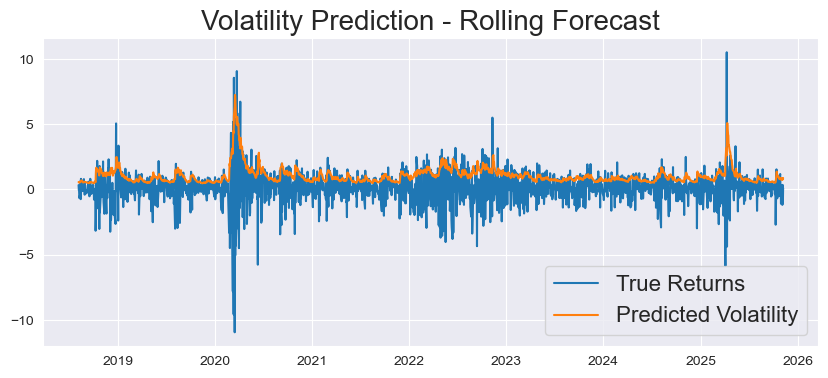

In [29]:
plt.figure(figsize=(10,4))
true, = plt.plot(spy_returns[-365*5:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [31]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of put option with respect to S_0
    
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)



In [42]:
#Investigate Delta Hedging on real stock data using Black-Scholes values for Delta

spy_log_returns = np.log(spy.pct_change()+1)
spy_volatility = spy_log_returns.rolling(window = 21).std()*np.sqrt(252)
spy_tte = (spy.index[-1] - spy.index).total_seconds()/(60*60*24*365)
    
K = int(spy['Close', 'SPY'].iloc[21])

spy['delta','SPY'] = np.nan

mask = spy.index[21:]

spy.loc[mask, ('delta', 'SPY')] = bs_call_delta(
    spy.loc[mask,('Close', 'SPY')],
    K,
    spy.loc[mask,spy_volatility],
    spy.loc[mask,spy_tte], 
    0)

final_stock_price = spy.iloc[-1]
    
call_payout = np.maximum(final_stock_price - K, 0)
    
hedge_pnl = np.sum(spy.diff()*\
                spy_delta.shift(1))

call_pay_hedged = call_payout - hedge_pnl


black_scholes_price = bs_call(
    spy.iloc[21],
    K,
    spy_volatility.iloc[21],
    spy.tte.iloc[21],
    0
    )
    
print(f' {SPY} Black-scholes price: ${black_scholes_price:.2f}')
    
    
print(f'{SPY} Call option value on historical data with delta hedging ${call_pay_hedged:.2f}')
    
print('-'*(100))

C:\Users\anshu\AppData\Local\Temp\ipykernel_32348\3292273744.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  spy_log_returns = np.log(spy.pct_change()+1)


ValueError: Cannot index with multidimensional key